# Importing some libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier, VotingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.preprocessing import Imputer , Normalizer , scale, LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.metrics import make_scorer, accuracy_score, classification_report, confusion_matrix
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas import get_dummies
import xgboost as xgb
import scipy
import json
import sys
import csv
import os
import tqdm
from tqdm import tqdm_notebook
from statistics import median, mean, mode

In [2]:
def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()
    
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()
    
def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
                    corr,
                    cmap = cmap,
                    square=True,
                    cbar_kws={ 'shrink' : .9 },
                    ax=ax,
                    annot = True,
                    annot_kws = { 'fontsize' : 12 }
                    )

def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title(( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) + ' ' + var_name ) #var_name+" Distribution")
        #ax.set_xticklabels( [] , visible=False )
        #ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

# Importing the dataset

In [3]:
df_train = pd.read_csv('../titanic_dataset/train.csv')

In [4]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df_test = pd.read_csv('../titanic_dataset/test.csv')

In [6]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Get summary of dataset

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [8]:
def num_missing(x):
    return sum(x.isnull())
print("Missing values per column:")
print(df_train.apply(num_missing, axis=0))

Missing values per column:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [9]:
print("Unique values per column:")
for col in df_train:
    print(col, ' ', len(df_train[col].unique()))

Unique values per column:
PassengerId   891
Survived   2
Pclass   3
Name   891
Sex   2
Age   89
SibSp   7
Parch   7
Ticket   681
Fare   248
Cabin   148
Embarked   4


In [10]:
traintest = pd.concat([df_train, df_test], axis = 0)
feats_counts = df_train.nunique(dropna = False)
constant_features = feats_counts.loc[feats_counts==1].index.tolist()
#traintest.drop(constant_features,axis = 1,inplace=True)

In [11]:
constant_features

[]

In [12]:
traintest.fillna('NaN', inplace=True)
train_enc =  pd.DataFrame(index = df_train.index)
for col in tqdm_notebook(traintest.columns):
    train_enc[col] = df_train[col].factorize()[0]
dup_cols = {}
for i, c1 in enumerate(tqdm_notebook(train_enc.columns)):
    for c2 in train_enc.columns[i + 1:]:
        if c2 not in dup_cols and np.all(train_enc[c1] == train_enc[c2]):
            dup_cols[c2] = c1
#traintest.drop(dup_cols.keys(), axis = 1,inplace=True)

In [13]:
dup_cols

{'PassengerId': 'Name'}

In [14]:
df_train.drop(['PassengerId'], axis = 1, inplace = True)
df_test.drop(['PassengerId'], axis = 1, inplace = True)

In [15]:
df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [16]:
df_test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [17]:
def percConvert(ser):
    return ser/float(ser[-1])
pd.crosstab(df_train["Pclass"],df_train["Survived"],margins=True).apply(percConvert, axis=1)

Survived,0,1,All
Pclass,,,
1,0.370370,0.629630,1.0
2,0.527174,0.472826,1.0
3,0.757637,0.242363,1.0
All,0.616162,0.383838,1.0


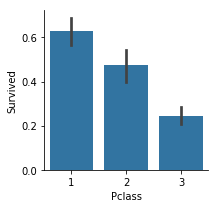

In [18]:
plot_categories(df_train, cat = 'Pclass', target = 'Survived')

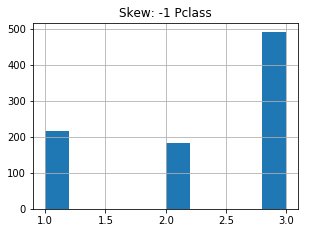

In [19]:
plot_histograms(df_train, ['Pclass'], 4,4)

In [20]:
for row in df_train:
    df_train['Title'] = df_train.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

for row in df_test:
    df_test['Title'] = df_test.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

In [21]:
def percConvert(ser):
    return ser/float(ser[-1])
pd.crosstab(df_train["Title"],df_train["Sex"],margins=True)

Sex,female,male,All
Title,,,
Capt,0,1,1
Col,0,2,2
Countess,1,0,1
Don,0,1,1
Dr,1,6,7
Jonkheer,0,1,1
Lady,1,0,1
Major,0,2,2
Master,0,40,40


In [22]:
for row in df_train:
    df_train['Title'] = df_train['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    df_train['Title'] = df_train['Title'].replace('Mlle', 'Miss')
    df_train['Title'] = df_train['Title'].replace('Ms', 'Miss')
    df_train['Title'] = df_train['Title'].replace('Mme', 'Mrs')

In [23]:
for row in df_test:
    df_test['Title'] = df_test['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    df_test['Title'] = df_test['Title'].replace('Mlle', 'Miss')
    df_test['Title'] = df_test['Title'].replace('Ms', 'Miss')
    df_test['Title'] = df_test['Title'].replace('Mme', 'Mrs')

In [24]:
def percConvert(ser):
    return ser/float(ser[-1])
pd.crosstab(df_train["Title"],df_train["Sex"],margins=True)

Sex,female,male,All
Title,,,
Master,0,40,40
Miss,185,0,185
Mr,0,517,517
Mrs,126,0,126
Rare,3,20,23
All,314,577,891


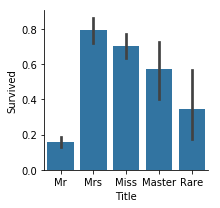

In [25]:
plot_categories(df_train, cat='Title', target='Survived')

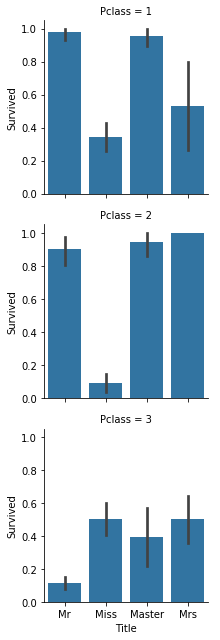

In [26]:
plot_categories(df_train, cat='Title', target='Survived', row='Pclass')

In [27]:
labelencoder = LabelEncoder()
df_train.iloc[:, 11] = labelencoder.fit_transform(df_train.iloc[:, 11])

In [28]:
labelencoder2 = LabelEncoder()
df_test.iloc[:, 10] = labelencoder2.fit_transform(df_test.iloc[:, 10])

In [29]:
df_test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,2
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,3
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,2
3,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,2
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,3


In [30]:
df_train.drop(['Name'], axis = 1, inplace = True)
df_test.drop(['Name'], axis = 1, inplace = True)

In [31]:
def percConvert(ser):
    return ser/float(ser[-1])
pd.crosstab(df_train["Sex"],df_train["Survived"],margins=True).apply(percConvert, axis=1)

Survived,0,1,All
Sex,,,
female,0.257962,0.742038,1.0
male,0.811092,0.188908,1.0
All,0.616162,0.383838,1.0


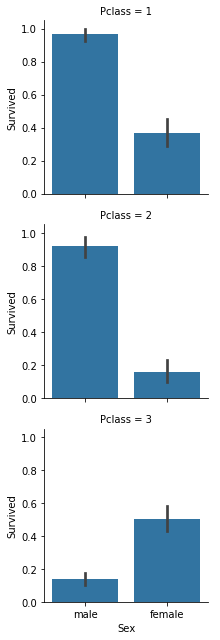

In [32]:
plot_categories(df_train, cat='Sex', target='Survived', row='Pclass')

In [33]:
labelencoderSexTrain = LabelEncoder()
df_train.iloc[:, 2] = labelencoderSexTrain.fit_transform(df_train.iloc[:, 2])
labelencoderSexTest = LabelEncoder()
df_test.iloc[:, 1] = labelencoderSexTest.fit_transform(df_test.iloc[:, 1])

In [34]:
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,0,3,1,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,1,1,0,38.0,1,0,PC 17599,71.2833,C85,C,3
2,1,3,0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,1,1,0,35.0,1,0,113803,53.1000,C123,S,3
4,0,3,1,35.0,0,0,373450,8.0500,NaN,S,2


In [35]:
df_test.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,3,1,34.5,0,0,330911,7.8292,NaN,Q,2
1,3,0,47.0,1,0,363272,7.0000,NaN,S,3
2,2,1,62.0,0,0,240276,9.6875,NaN,Q,2
3,3,1,27.0,0,0,315154,8.6625,NaN,S,2
4,3,0,22.0,1,1,3101298,12.2875,NaN,S,3


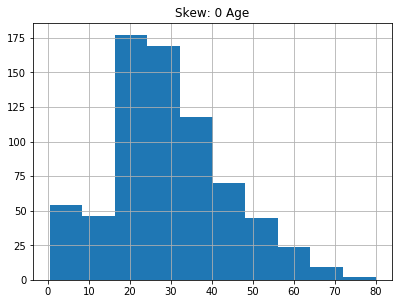

In [36]:
plot_histograms(df_train, ['Age'], 3,3)

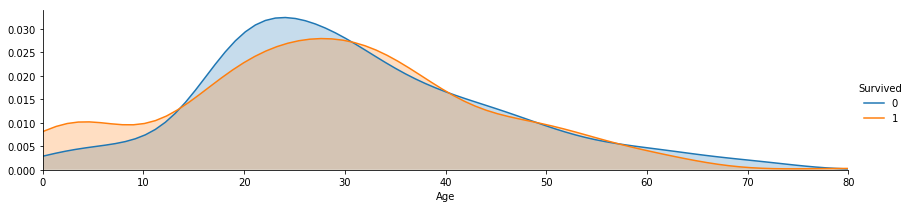

In [37]:
plot_distribution(df_train, 'Age', 'Survived')

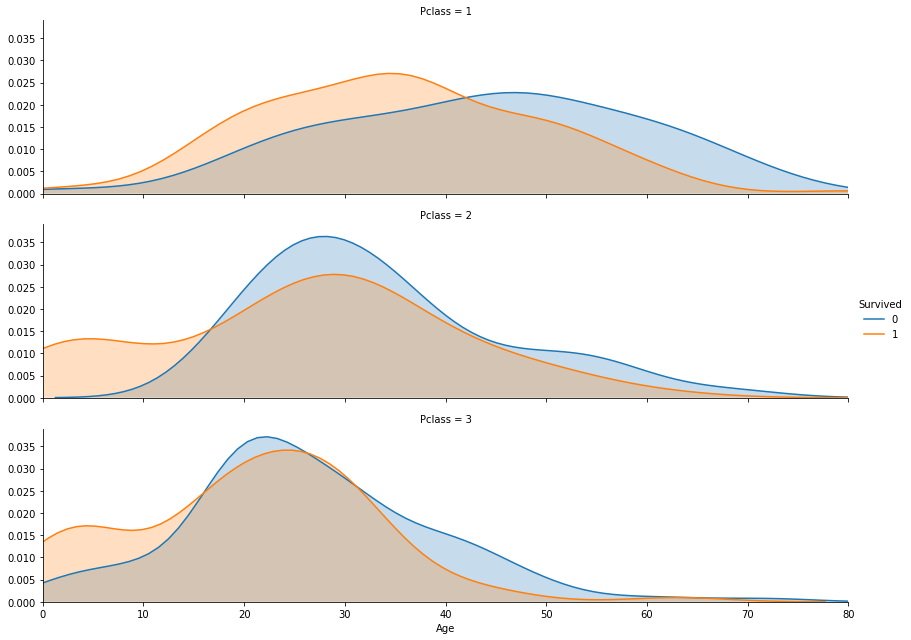

In [38]:
plot_distribution(df_train, 'Age', 'Survived', row='Pclass')

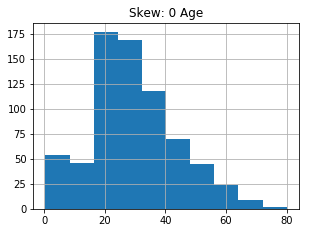

In [39]:
plot_histograms(df_train, ['Age'], 4,4)

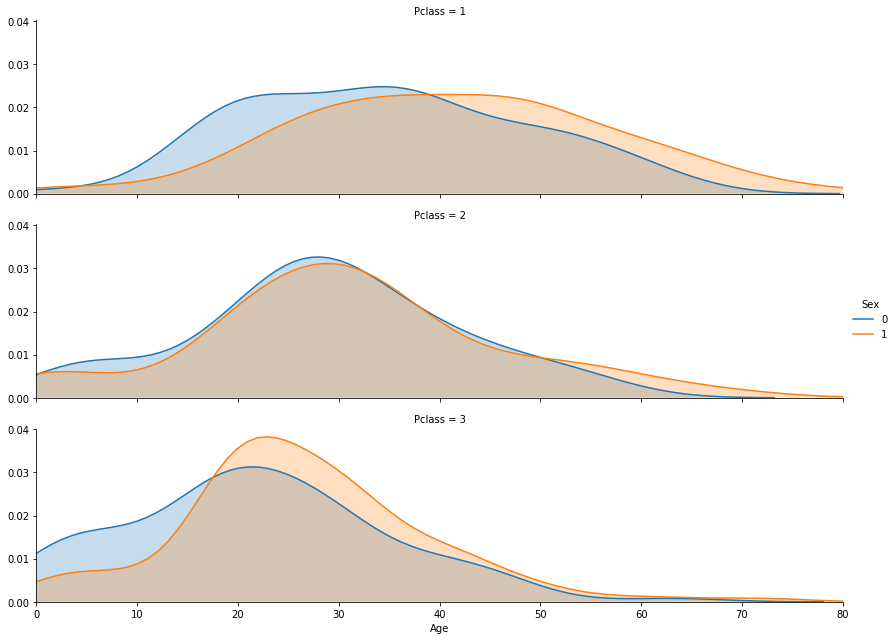

In [40]:
plot_distribution(df_train, 'Age', 'Sex', row='Pclass')

In [41]:
#We iterate over all the Pclass and Sex to get the median of the Ages
w = 5
h = 5
guess_age = [[0 for x in range(w)] for y in range(h)] 
df_train.fillna('NaN', inplace=True)
for i in range(2):
    for j in range(4):
        temp_ages = []
        if (j == 0):
            continue
        for index, row in df_train.iterrows():
            if (row['Age'] == 'NaN'):
                continue
            elif (row['Pclass'] == j and row['Sex'] == i):
                temp_ages.append(row['Age'])
        guess_age[i][j] = median(temp_ages)

In [42]:
guess_age

[[0, 35.0, 28.0, 21.5, 0],
 [0, 40.0, 30.0, 25.0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0]]

In [43]:
for i in range(2):
    for j in range(4):
        if (j == 0):
            continue
        for index, row in df_train.iterrows():
            if (row['Age'] == 'NaN' and row['Pclass'] == j and row['Sex'] == i):
                df_train.iloc[index, 3] = guess_age[i][j]

In [44]:
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,0,3,1,22,1,0,A/5 21171,7.2500,NaN,S,2
1,1,1,0,38,1,0,PC 17599,71.2833,C85,C,3
2,1,3,0,26,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,1,1,0,35,1,0,113803,53.1000,C123,S,3
4,0,3,1,35,0,0,373450,8.0500,NaN,S,2


In [45]:
df_test.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,3,1,34.5,0,0,330911,7.8292,NaN,Q,2
1,3,0,47.0,1,0,363272,7.0000,NaN,S,3
2,2,1,62.0,0,0,240276,9.6875,NaN,Q,2
3,3,1,27.0,0,0,315154,8.6625,NaN,S,2
4,3,0,22.0,1,1,3101298,12.2875,NaN,S,3


In [46]:
#We iterate over all the Pclass and Sex to get the median of the Ages
w = 5
h = 5
guess_age = [[0 for x in range(w)] for y in range(h)] 
df_test.fillna('NaN', inplace=True)
for i in range(2):
    for j in range(4):
        temp_ages = []
        if (j == 0):
            continue
        for index, row in df_test.iterrows():
            if (row['Age'] == 'NaN'):
                continue
            elif (row['Pclass'] == j and row['Sex'] == i):
                temp_ages.append(row['Age'])
        guess_age[i][j] = median(temp_ages)

In [47]:
for i in range(2):
    for j in range(4):
        if (j == 0):
            continue
        for index, row in df_test.iterrows():
            if (row['Age'] == 'NaN' and row['Pclass'] == j and row['Sex'] == i):
                df_test.iloc[index, 2] = guess_age[i][j]

In [48]:
df_test.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,3,1,34.5,0,0,330911,7.8292,NaN,Q,2
1,3,0,47,1,0,363272,7,NaN,S,3
2,2,1,62,0,0,240276,9.6875,NaN,Q,2
3,3,1,27,0,0,315154,8.6625,NaN,S,2
4,3,0,22,1,1,3101298,12.2875,NaN,S,3


In [49]:
df_train['Family'] = (df_train['SibSp'] + df_train['Parch'])
df_test['Family'] = (df_test['SibSp'] + df_test['Parch'])

In [50]:
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Family
0,0,3,1,22,1,0,A/5 21171,7.2500,NaN,S,2,1
1,1,1,0,38,1,0,PC 17599,71.2833,C85,C,3,1
2,1,3,0,26,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0
3,1,1,0,35,1,0,113803,53.1000,C123,S,3,1
4,0,3,1,35,0,0,373450,8.0500,NaN,S,2,0


In [51]:
df_test.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Family
0,3,1,34.5,0,0,330911,7.8292,NaN,Q,2,0
1,3,0,47,1,0,363272,7,NaN,S,3,1
2,2,1,62,0,0,240276,9.6875,NaN,Q,2,0
3,3,1,27,0,0,315154,8.6625,NaN,S,2,0
4,3,0,22,1,1,3101298,12.2875,NaN,S,3,2


In [52]:
df_train.drop(['SibSp', 'Parch'], axis = 1, inplace = True)
df_test.drop(['SibSp', 'Parch'], axis = 1, inplace = True)

In [53]:
df_train.head()

,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,Family
0,0,3,1,22,A/5 21171,7.2500,NaN,S,2,1
1,1,1,0,38,PC 17599,71.2833,C85,C,3,1
2,1,3,0,26,STON/O2. 3101282,7.9250,NaN,S,1,0
3,1,1,0,35,113803,53.1000,C123,S,3,1
4,0,3,1,35,373450,8.0500,NaN,S,2,0


In [54]:
df_test.head()

,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,Family
0,3,1,34.5,330911,7.8292,NaN,Q,2,0
1,3,0,47,363272,7,NaN,S,3,1
2,2,1,62,240276,9.6875,NaN,Q,2,0
3,3,1,27,315154,8.6625,NaN,S,2,0
4,3,0,22,3101298,12.2875,NaN,S,3,2


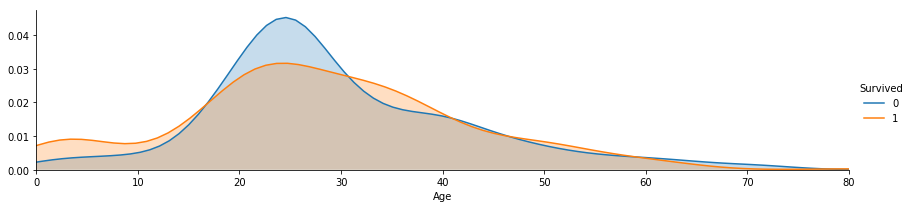

In [55]:
plot_distribution(df_train, 'Age', 'Survived')

In [56]:
for index, row in df_train.iterrows():
    val = -1
    if row['Age'] <= 10 :
        val = 0
    elif row['Age'] <= 20:
        val = 1
    elif row['Age'] <= 30:
        val = 2
    elif row['Age'] <= 40:
        val = 3
    elif row['Age'] <= 50:
        val = 4
    else:
        val = 5
    df_train.iloc[index, 3] = val

In [57]:
df_train.head()

,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,Family
0,0,3,1,2,A/5 21171,7.2500,NaN,S,2,1
1,1,1,0,3,PC 17599,71.2833,C85,C,3,1
2,1,3,0,2,STON/O2. 3101282,7.9250,NaN,S,1,0
3,1,1,0,3,113803,53.1000,C123,S,3,1
4,0,3,1,3,373450,8.0500,NaN,S,2,0


In [58]:
for index, row in df_test.iterrows():
    val = -1
    if row['Age'] <= 10 :
        val = 0
    elif row['Age'] <= 20:
        val = 1
    elif row['Age'] <= 30:
        val = 2
    elif row['Age'] <= 40:
        val = 3
    elif row['Age'] <= 50:
        val = 4
    else:
        val = 5
    df_test.iloc[index, 2] = val

In [59]:
df_test.head()

,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,Family
0,3,1,3,330911,7.8292,NaN,Q,2,0
1,3,0,4,363272,7,NaN,S,3,1
2,2,1,5,240276,9.6875,NaN,Q,2,0
3,3,1,2,315154,8.6625,NaN,S,2,0
4,3,0,2,3101298,12.2875,NaN,S,3,2


In [60]:
df_train.drop(['Ticket'], axis = 1, inplace = True)
df_test.drop(['Ticket'], axis = 1, inplace = True)

In [61]:
df_train.head()

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,Family
0,0,3,1,2,7.2500,NaN,S,2,1
1,1,1,0,3,71.2833,C85,C,3,1
2,1,3,0,2,7.9250,NaN,S,1,0
3,1,1,0,3,53.1000,C123,S,3,1
4,0,3,1,3,8.0500,NaN,S,2,0


In [62]:
df_test.head()

,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,Family
0,3,1,3,7.8292,NaN,Q,2,0
1,3,0,4,7,NaN,S,3,1
2,2,1,5,9.6875,NaN,Q,2,0
3,3,1,2,8.6625,NaN,S,2,0
4,3,0,2,12.2875,NaN,S,3,2


In [63]:
for index, row in df_train.iterrows():
    df_train.iloc[index, 4] = int(df_train.iloc[index, 4])

In [64]:
temp_fare = []
for index, row in df_test.iterrows():
    if row['Fare'] != 'NaN':
        temp_fare.append(row['Fare'])

for index, row in df_test.iterrows():
    if row['Fare'] == 'NaN':
        df_test.iloc[index, 3] = mean(temp_fare)

In [65]:
for index, row in df_test.iterrows():
    df_test.iloc[index, 3] = int(df_test.iloc[index, 3])

In [66]:
df_test.head()

,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,Family
0,3,1,3,7,NaN,Q,2,0
1,3,0,4,7,NaN,S,3,1
2,2,1,5,9,NaN,Q,2,0
3,3,1,2,8,NaN,S,2,0
4,3,0,2,12,NaN,S,3,2


In [67]:
df_train.head()

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,Family
0,0,3,1,2,7.0,NaN,S,2,1
1,1,1,0,3,71.0,C85,C,3,1
2,1,3,0,2,7.0,NaN,S,1,0
3,1,1,0,3,53.0,C123,S,3,1
4,0,3,1,3,8.0,NaN,S,2,0


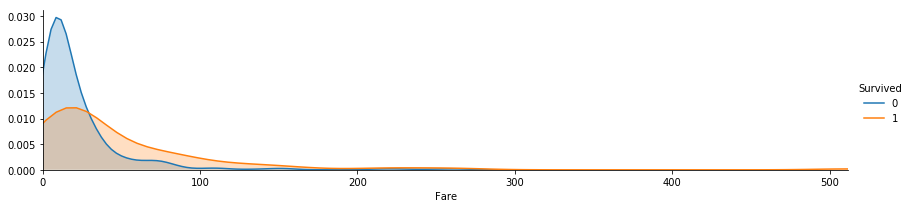

In [68]:
plot_distribution(df_train, 'Fare', 'Survived')

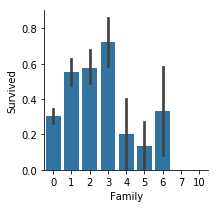

In [69]:
plot_categories(df_train, 'Family', 'Survived')

In [70]:
df_train.drop(['Cabin'], axis = 1, inplace = True)
df_test.drop(['Cabin'], axis = 1, inplace = True)

In [71]:
df_test.head()

,Pclass,Sex,Age,Fare,Embarked,Title,Family
0,3,1,3,7,Q,2,0
1,3,0,4,7,S,3,1
2,2,1,5,9,Q,2,0
3,3,1,2,8,S,2,0
4,3,0,2,12,S,3,2


In [72]:
df_train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,Family
0,0,3,1,2,7.0,S,2,1
1,1,1,0,3,71.0,C,3,1
2,1,3,0,2,7.0,S,1,0
3,1,1,0,3,53.0,S,3,1
4,0,3,1,3,8.0,S,2,0


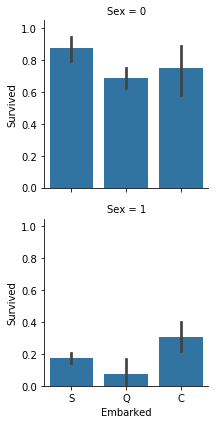

In [73]:
plot_categories(df_train, 'Embarked', 'Survived', row = 'Sex')

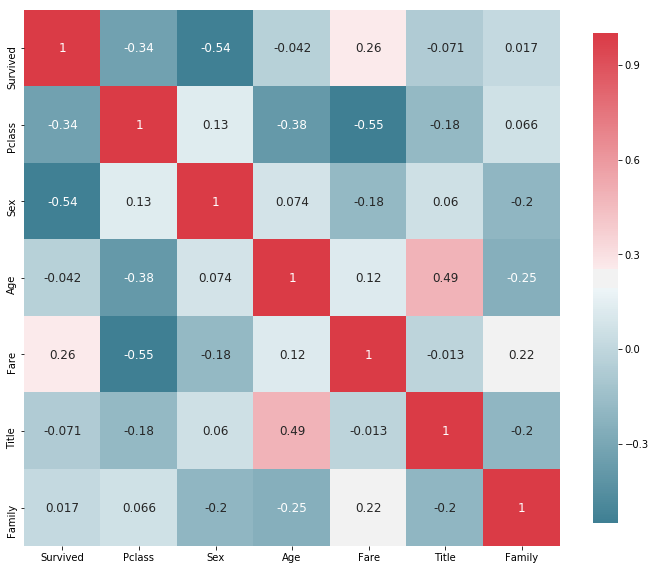

In [74]:
plot_correlation_map(df_train)

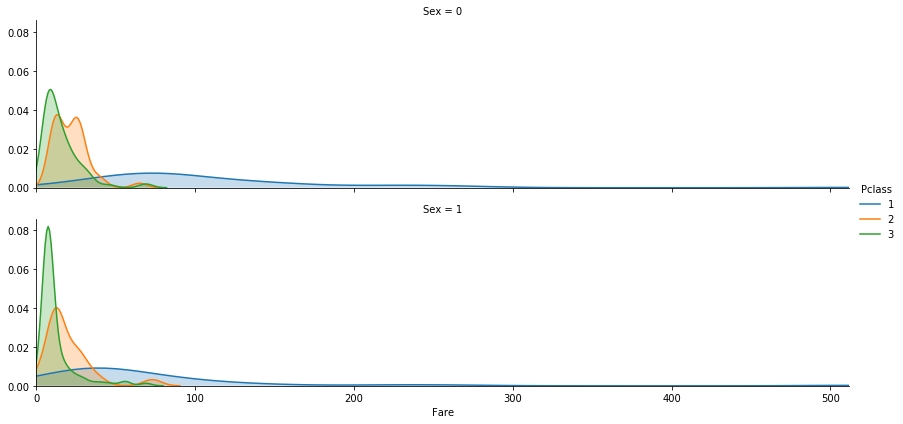

In [75]:
plot_distribution(df_train, 'Fare', 'Pclass', row = 'Sex')

In [76]:
df_train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,Family
0,0,3,1,2,7.0,S,2,1
1,1,1,0,3,71.0,C,3,1
2,1,3,0,2,7.0,S,1,0
3,1,1,0,3,53.0,S,3,1
4,0,3,1,3,8.0,S,2,0


In [77]:
for index, row in df_train.iterrows():
    if row['Embarked'] == 'NaN':
        df_train.iloc[index, 5] = 'S'

In [78]:
for index, row in df_train.iterrows():
    if row['Embarked'] == 'NaN':
        print("Yes")

In [79]:
labelencoder = LabelEncoder()
df_train.iloc[:, 5] = labelencoder.fit_transform(df_train.iloc[:, 5])

In [80]:
labelencoder = LabelEncoder()
df_test.iloc[:, 4] = labelencoder.fit_transform(df_test.iloc[:, 4])

In [81]:
df_train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,Family
0,0,3,1,2,7.0,2,2,1
1,1,1,0,3,71.0,0,3,1
2,1,3,0,2,7.0,2,1,0
3,1,1,0,3,53.0,2,3,1
4,0,3,1,3,8.0,2,2,0


In [82]:
df_test.head()

,Pclass,Sex,Age,Fare,Embarked,Title,Family
0,3,1,3,7,1,2,0
1,3,0,4,7,2,3,1
2,2,1,5,9,1,2,0
3,3,1,2,8,2,2,0
4,3,0,2,12,2,3,2


In [87]:
df_train['IsAlone'] = (df_train['Family'] == 0)

In [89]:
df_test['IsAlone'] = (df_test['Family'] == 0)

In [90]:
df_train['Product'] = df_train['Age'] * df_train['Pclass']
df_test['Product'] = df_test['Age'] * df_test['Pclass']

In [92]:
labelencoder = LabelEncoder()
df_train.iloc[:, 8] = labelencoder.fit_transform(df_train.iloc[:, 8])

In [95]:
labelencoder = LabelEncoder()
df_test.iloc[:, 7] = labelencoder.fit_transform(df_test.iloc[:, 7])

In [96]:
df_train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,Family,IsAlone,Product
0,0,3,1,2,7.0,2,2,1,0,6
1,1,1,0,3,71.0,0,3,1,0,3
2,1,3,0,2,7.0,2,1,0,1,6
3,1,1,0,3,53.0,2,3,1,0,3
4,0,3,1,3,8.0,2,2,0,1,9


In [97]:
df_test.head()

,Pclass,Sex,Age,Fare,Embarked,Title,Family,IsAlone,Product
0,3,1,3,7,1,2,0,1,9
1,3,0,4,7,2,3,1,0,12
2,2,1,5,9,1,2,0,1,10
3,3,1,2,8,2,2,0,1,6
4,3,0,2,12,2,3,2,0,6


In [98]:
X = df_train.iloc[:, [1,2,3,4,5,6,7,8,9]].values

In [99]:
y = df_train.iloc[:, 0].values

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X , y , test_size = 0.33)

# Logisitic Regression

In [101]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, y_train) * 100, 2)
acc_log

80.03

In [102]:
coeff_df = pd.DataFrame(df_train.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])
coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
2,Age,0.096171
3,Fare,0.004542
4,Embarked,-0.056582
5,Title,-0.104036
8,Product,-0.160419
0,Pclass,-0.318891
6,Family,-0.385454
7,IsAlone,-0.428273
1,Sex,-2.418294


# Support Vector Machines

In [103]:
svc = SVC()
svc.fit(X_train, y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, y_train) * 100, 2)
acc_svc

87.42

# KNN 

In [104]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, y_train) * 100, 2)
acc_knn

80.03

# Gaussian Naive Bayes 

In [105]:
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, y_train) * 100, 2)
acc_gaussian

80.7

# Linear SVC

In [106]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, y_train) * 100, 2)
acc_linear_svc

76.17

# Random Forest

In [107]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, y_train)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
acc_random_forest

93.12

# K-fold Cross validation

In [108]:
kfold = KFold(n_splits=10, random_state=22) 
xyz=[]
accuracy=[]
std=[]
classifiers=['Linear Svm','Radial Svm','Logistic Regression','KNN','Decision Tree','Naive Bayes','Random Forest']
models=[SVC(kernel='linear'),SVC(kernel='rbf'),LogisticRegression(),KNeighborsClassifier(n_neighbors=9),DecisionTreeClassifier(),GaussianNB(),RandomForestClassifier(n_estimators=100)]
for i in models:
    model = i
    cv_result = cross_val_score(model,X,y, cv = kfold,scoring = "accuracy")
    cv_result=cv_result
    xyz.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)
new_models_dataframe2=pd.DataFrame({'CV Mean':xyz,'Std':std},index=classifiers)
new_models_dataframe2

,CV Mean,Std
Linear Svm,0.793483,0.042130
Radial Svm,0.768851,0.034818
Logistic Regression,0.789039,0.028445
KNN,0.738564,0.044452
Decision Tree,0.804769,0.039599
Naive Bayes,0.804782,0.030065
Random Forest,0.817116,0.044372


# Grid search for hyper parameter tuning

In [109]:
C=[0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1]
gamma=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
kernel=['rbf','linear']
hyper={'kernel':kernel,'C':C,'gamma':gamma}
gd=GridSearchCV(estimator=SVC(),param_grid=hyper,verbose=True)
gd.fit(X,y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:  1.2min finished


0.7901234567901234
SVC(C=0.9, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


# Ensembling:
## 1. Voting classifier
## 2. Bagging
## 3. Boosting

In [110]:
ensemble_lin_rbf=VotingClassifier(estimators=[('KNN',KNeighborsClassifier(n_neighbors=10)),
                                              ('RBF',SVC(probability=True,kernel='rbf',C=0.5,gamma=0.1)),
                                              ('RFor',RandomForestClassifier(n_estimators=500,random_state=0)),
                                              ('LR',LogisticRegression(C=0.05)),
                                              ('DT',DecisionTreeClassifier(random_state=0)),
                                              ('NB',GaussianNB()),
                                              ('svm',SVC(kernel='linear',probability=True))
                                             ],
                       voting='soft').fit(X_train,y_train)
print('The accuracy for ensembled model is:',ensemble_lin_rbf.score(X_test,y_test))
cross=cross_val_score(ensemble_lin_rbf,X,y, cv = 10,scoring = "accuracy")
print('The cross validated score is',cross.mean())

The accuracy for ensembled model is: 0.8372881355932204
The cross validated score is 0.8182734649869481


In [111]:
model=BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=3),random_state=0,n_estimators=700)
model.fit(X_train, y_train)
prediction=model.predict(X_test)
print('The accuracy for bagged KNN is:',accuracy_score(prediction,y_test))
result=cross_val_score(model,X,y,cv=10,scoring='accuracy')
print('The cross validated score for bagged KNN is:',result.mean())

The accuracy for bagged KNN is: 0.7559322033898305
The cross validated score for bagged KNN is: 0.762217114969924


In [112]:
ada=AdaBoostClassifier(n_estimators=200,random_state=0,learning_rate=0.1)
result=cross_val_score(ada,X,y,cv=10,scoring='accuracy')
print('The cross validated score for AdaBoost is:',result.mean())

The cross validated score for AdaBoost is: 0.8271998070593576


In [113]:
grad=GradientBoostingClassifier(n_estimators=500,random_state=0,learning_rate=0.1)
result=cross_val_score(grad,X,y,cv=10,scoring='accuracy')
print('The cross validated score for Gradient Boosting is:',result.mean())

The cross validated score for Gradient Boosting is: 0.8429176597435022


In [114]:
test = df_test.values

In [118]:
Y_pred = random_forest.predict(test)

In [122]:
df_test = pd.read_csv('../titanic_dataset/test.csv')

In [123]:
submission = pd.DataFrame({
        "PassengerId": df_test['PassengerId'],
        "Survived": Y_pred
    })

In [126]:
submission.to_csv('submission.csv', index=False)